In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from astropy.coordinates import search_around_sky
from dust_extinction.averages import RL85_MWGC, RRP89_MWGC, B92_MWAvg, I05_MWAvg, CT06_MWLoc, CT06_MWGC, GCC09_MWAvg, F11_MWGC, G21_MWAvg, D22_MWAvg
from scipy.spatial import KDTree
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm
from astropy.modeling import models, fitting
from astropy.visualization.wcsaxes import add_scalebar

from importlib import reload

In [3]:
%cd .. 
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm
import surface_density_plot as sdp

reload(ex)
reload(sdp)
%cd notebooks

<module 'surface_density_plot' from '/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py'>

In [4]:
ext = CT06_MWGC() # F182M - F410M = 2
Av_const = (2) / (ext(182/100*u.um) - ext(410/100*u.um))
Av_const

21.694495165694764

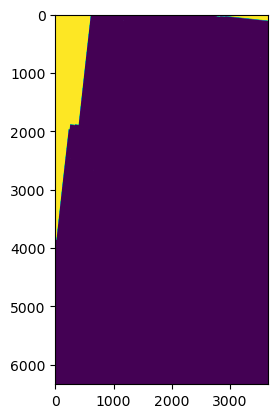

In [5]:
# improved edge masking
pos=SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l=113.8*u.arcsec
w=3.3*u.arcmin

cutout_405 = cm.get_cutout_405(pos, w, l)
cutout_187 = cm.get_cutout_187(pos, w, l)
cutout_212 = cm.get_cutout_212(pos, w, l)

mas_cut_405 = np.logical_or(np.isnan(cutout_405.data), cutout_405.data == 0)
mas_cut_187 = np.logical_or(np.isnan(cutout_187.data), cutout_187.data == 0)
mas_cut_212 = np.logical_or(np.isnan(cutout_212.data), cutout_212.data == 0)
mask_cutouts = np.logical_and(mas_cut_405, mas_cut_187)
mask_cutouts = np.logical_and(mask_cutouts, mas_cut_212)

plt.imshow(mask_cutouts)

# Prepare Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
shape = cutout_405.shape

In [8]:
band1 = 'f182m'
band2 = 'f212n'

cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))
color_cut = 0.55
Av_const = (color_cut) / (ext(int(band1[1:-1])/100*u.um) - ext(int(band2[1:-1])/100*u.um))
mask = (cat_filament.color(band1, band2) > color_cut)
mask = np.logical_or(mask, np.isnan(cat_filament.band(band1)) & ~np.isnan(cat_filament.band('f410m')))
cat_red = JWSTCatalog(cat_filament.catalog[mask])

grid_mask = cm.get_cutout_187(pos, w, l).data == 0

Av = cat_red.get_Av(band1, 'f212n', ext=CT06_MWLoc())
too_red = np.isnan(np.array(cat_red.band(band1))) & ~(np.isnan(np.array(cat_red.band('f410m'))) & np.isnan(np.array(cat_red.band('f405n'))))
Av_fill = 64
Av[too_red] = Av_fill


In [9]:
#extinction_map(cat, Av, shape, wcs, fwhm=30, k=5, mask=None, Av_const=0)
Av_map = sdp.extinction_map(cat_red, Av, shape, ww, fwhm=30, k=5, mask=grid_mask)
Av_map[mask_cutouts] = np.nan

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


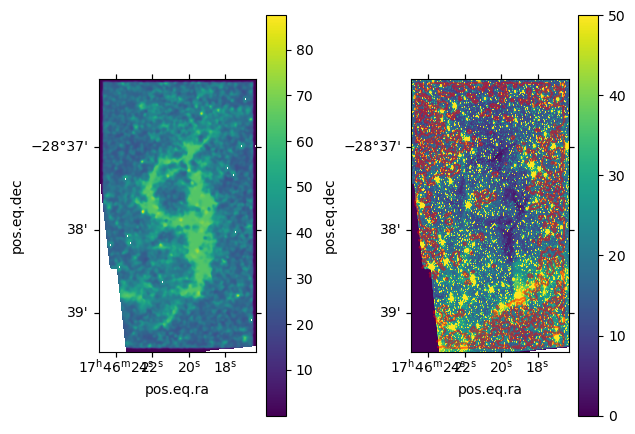

In [10]:
ax = plt.subplot(121, projection=ww)
im = ax.imshow(Av_map)
#ax.contour(Av_map, levels=[30], colors='r')
plt.colorbar(im)

ax = plt.subplot(122, projection=ww)
im = ax.imshow(cutout_405.data, vmin=0, vmax=50)
ax.contour(Av_map, levels=[30], colors='r', alpha=0.5)
plt.colorbar(im)
plt.tight_layout()

In [11]:
def change_ext(cat, ww, shape, ext=CT06_MWLoc(), color_cut=0.55, Av_fill=85, fwhm=30, k=5):
    band1 = 'f182m'
    band2 = 'f212n'

    Av_const = (color_cut) / (ext(int(band1[1:-1])/100*u.um) - ext(int(band2[1:-1])/100*u.um))
    mask = (cat.color(band1, band2) > color_cut)
    mask = np.logical_or(mask, np.isnan(cat.band(band1)) & ~np.isnan(cat.band('f410m')))
    cat_red = JWSTCatalog(cat.catalog[mask])

    grid_mask = cm.get_cutout_187(pos, w, l).data == 0

    Av = cat_red.get_Av(band1, band2, ext=ext)
    too_red = np.isnan(np.array(cat_red.band('f182m'))) & ~(np.isnan(np.array(cat_red.band('f410m'))) & np.isnan(np.array(cat_red.band('f405n'))))
    Av[too_red] = Av_fill

    Av_map = sdp.extinction_map(cat_red, Av, shape, ww, fwhm=fwhm, k=k, mask=grid_mask)
    Av_map = Av_map - Av_const
    Av_map[Av_map < 0] = np.nan
    
    return Av_map

In [12]:
def change_ext_red(cat, ww, shape, ext=CT06_MWLoc(), color_cut=2.0, Av_fill=85, fwhm=30, k=5):
    band1 = 'f182m'
    band2 = 'f410m'

    Av_const = (color_cut) / (ext(int(band1[1:-1])/100*u.um) - ext(int(band2[1:-1])/100*u.um))
    mask = (cat.color(band1, band2) > color_cut)
    mask = np.logical_or(mask, np.isnan(cat.band(band1)) & ~np.isnan(cat.band('f410m')))
    cat_red = JWSTCatalog(cat.catalog[mask])

    grid_mask = cm.get_cutout_187(pos, w, l).data == 0

    Av = cat_red.get_Av(band1, band2, ext=ext)
    too_red = np.isnan(np.array(cat_red.band('f182m'))) & ~(np.isnan(np.array(cat_red.band('f410m'))) & np.isnan(np.array(cat_red.band('f405n'))))
    Av[too_red] = Av_fill

    Av_map = sdp.extinction_map(cat_red, Av, shape, ww, fwhm=fwhm, k=k, mask=grid_mask)
    Av_map = Av_map - Av_const
    Av_map[Av_map < 0] = np.nan

    return Av_map

# Mass Measurements

In [210]:
ext_map = change_ext_red(cat_filament, ww, shape, ext=CT06_MWLoc(), Av_fill=85)
#ex.make_extinction_map(ext=CT06_MWLoc(), Av_fill=85)
#ww = ex.get_wcs()
ex.get_mass_estimate(ext_map, ww)

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 11593.64938635 solMass>

In [211]:
#ext_map = ex.make_extinction_map(ext=CT06_MWGC(), Av_fill=85)
ext_map = change_ext_red(cat_filament, ww, shape, ext=CT06_MWGC(), Av_fill=85)
ex.get_mass_estimate(ext_map, ww)

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 11593.64938635 solMass>

In [212]:
#ext_map = ex.make_extinction_map(ext=I05_MWAvg(), Av_fill=80)
ext_map = change_ext_red(cat_filament, ww, shape, ext=I05_MWAvg(), Av_fill=80)
ex.get_mass_estimate(ext_map, ww)

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 10916.74772044 solMass>

In [213]:
#ext_map = ex.make_extinction_map(ext=RRP89_MWGC(), Av_fill=80)
ext_map = change_ext_red(cat_filament, ww, shape, ext=RRP89_MWGC(), Av_fill=80)
ex.get_mass_estimate(ext_map, ww)


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 10903.8017814 solMass>

In [214]:
#ext_map = ex.make_extinction_map(ext=D22_MWAvg(), Av_fill=76)
ext_map = change_ext_red(cat_filament, ww, shape, ext=D22_MWAvg(), Av_fill=76)
ex.get_mass_estimate(ext_map, ww)

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 10339.52639861 solMass>

In [215]:
#ext_map = ex.make_extinction_map(ext=G21_MWAvg(), Av_fill=75)
ext_map = change_ext_red(cat_filament, ww, shape, ext=G21_MWAvg(), Av_fill=75)
ex.get_mass_estimate(ext_map, ww)


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 10206.66286583 solMass>

In [216]:
#ext_map = ex.make_extinction_map(ext=RL85_MWGC(), Av_fill=70)
ext_map = change_ext_red(cat_filament, ww, shape, ext=RL85_MWGC(), Av_fill=70)
ex.get_mass_estimate(ext_map, ww)


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 9522.94456893 solMass>

In [217]:
#ext_map = ex.make_extinction_map(ext=F11_MWGC(), Av_fill=60)
ext_map = change_ext_red(cat_filament, ww, shape, ext=F11_MWGC(), Av_fill=60)
ex.get_mass_estimate(ext_map, ww)


/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


<Quantity 8156.02721048 solMass>

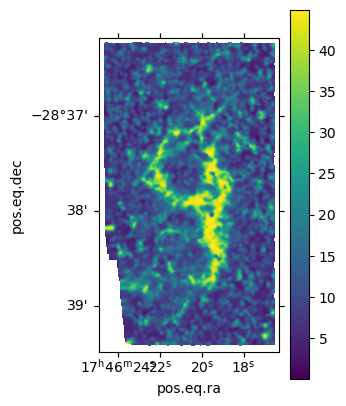

In [218]:
ax = plt.subplot(121, projection=ww)
im = ax.imshow(ext_map)
#ax.contour(ext_map, levels=[30], colors='r')
plt.colorbar(im)

In [14]:
ext_laws = [RL85_MWGC(), RRP89_MWGC(), I05_MWAvg(), CT06_MWLoc(), CT06_MWGC(), F11_MWGC(), G21_MWAvg(), D22_MWAvg()]
av_fills = [70, 80, 80, 85, 85, 60, 75, 76]
masses = []
for i, ext in enumerate(ext_laws):
    ext_map = ex.make_extinction_map(ext=ext, Av_fill=av_fills[i])
    masses.append(ex.get_mass_estimate(ext_map, ww).value)

In [15]:
masses

[8177.074439840178,
 9091.47047615733,
 9095.121345127518,
 9555.805611222466,
 9555.805611222466,
 7275.308232561079,
 8629.563783865719,
 8719.514918498797]

In [16]:
np.min(masses)

7275.308232561079

In [17]:
np.max(masses)

9555.805611222466

# Plot Extinction Map

In [13]:
ext_map = change_ext_red(cat_filament, ww, shape, ext=CT06_MWLoc(), Av_fill=85, fwhm=15)#, Av_fill=85)
#ext_map[mask_cutouts] = np.nan
#ex.make_extinction_map(ext=CT06_MWLoc(), Av_fill=85, color_cut=2)

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/surface_density_plot.py:38: UserWarning: Warning: converting a masked element to nan.
  grid[y, x] = value[i]


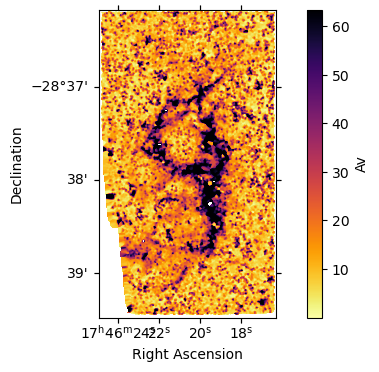

In [17]:
#ext_map[ext_map <= 18] = np.nan
fig = plt.figure(figsize=(8, 4))
ww = ex.get_wcs()
ext_map_c = ext_map.copy()
mask_ext = ext_map_c<=0
ext_map_c[mask_ext] = np.nan
mask_greater = ext_map_c > 85-21.6
ext_map_c[mask_greater] = np.nan

ax = plt.subplot(projection=ww)
im = ax.imshow(ext_map_c, origin='lower', cmap='inferno_r', interpolation="none")
plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('Right Ascension', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)

In [18]:
stellar_density_map = sdp.stellar_density(cat_red, shape, ww, 5)
#ex.make_stellar_density_map()
stellar_density_map[stellar_density_map == 0] = np.nan
#stellar_density_map[np.isnan(ext_map_c)] = np.nan
stellar_density_map[mask_cutouts] = np.nan
#stellar_density_map[stellar_density_map > 20] = np.nan

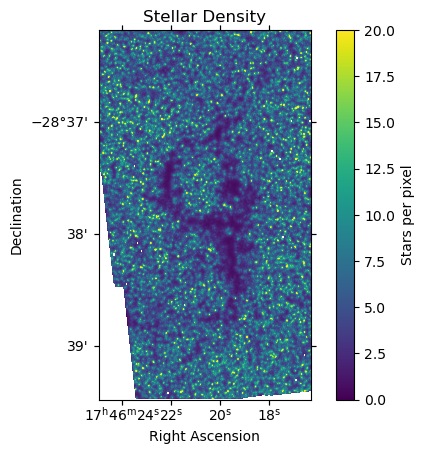

In [19]:
ax = plt.subplot(projection=ww)
im = ax.imshow(stellar_density_map, origin='lower', vmin=0, vmax=20)
#plt.contour(stellar_density_map, levels=[2], colors='white')
ax.set_title('Stellar Density')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Stars per pixel', ax=ax)

In [20]:
separation_map = sdp.stellar_separation(cat_red, shape, ww, 5)
#ex.make_stellar_separation_map(k=5)
#separation_map[separation_map == 0] = np.nan
#separation_map[separation_map < 0.1] = np.nan
#separation_map[separation_map > 4] = np.nan
separation_map[np.isnan(ext_map_c)] = np.nan

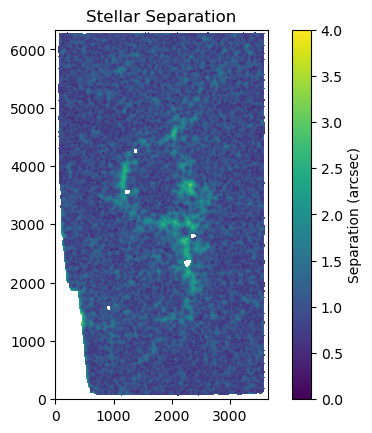

In [21]:
im = plt.imshow(separation_map, origin='lower', vmin=0, vmax=4)
#plt.contour(stellar_density_map, levels=[2.5], colors='white')
plt.title('Stellar Separation')
plt.colorbar(im, label='Separation (arcsec)')

In [22]:
# Define the physical size and distance
L = 0.5 * u.pc  # physical size in parsecs
D = 5 * u.kpc   # distance in kiloparsecs

# Calculate the angular size in radians
theta_rad = (L / D).to(u.radian, equivalencies=u.dimensionless_angles())

# Convert the angular size to arcseconds
theta_arcsec = theta_rad.to(u.arcsec)

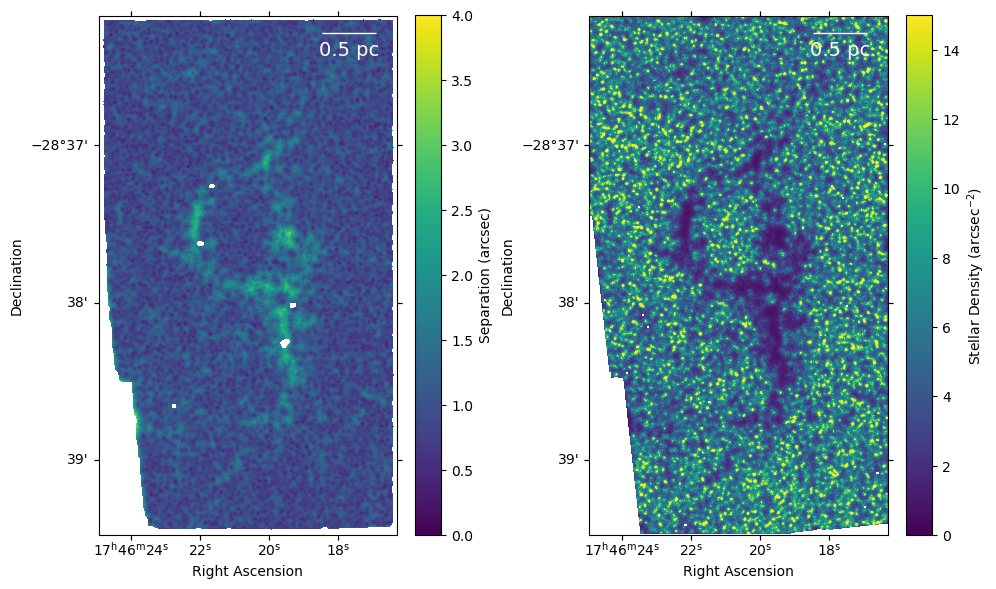

In [23]:
fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot(122, projection=ww)
im = ax1.imshow(stellar_density_map, origin='lower', vmin=0, vmax=15)
#ax1.set_title('Stellar Density')
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
fig.colorbar(im, label='Stellar Density (arcsec$^{-2}$)', ax=ax1)
add_scalebar(ax1, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})


plt.tight_layout()

ax2 = plt.subplot(121, projection=ww)
im = ax2.imshow(separation_map, origin='lower', vmin=0, vmax=4)
#ax2.set_title('Stellar Separation')
ax2.set_xlabel('Right Ascension')
ax2.set_ylabel('Declination')
fig.colorbar(im, label='Separation (arcsec)', ax=ax2)
add_scalebar(ax2, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})


plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_stellar_density_separation.pdf', bbox_inches='tight')

(0.0, 4.0)

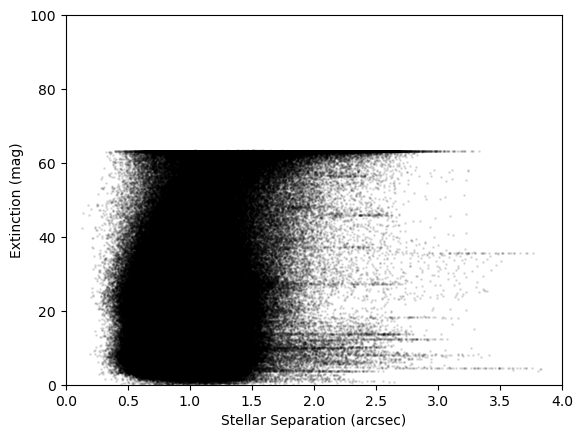

In [24]:
plt.scatter(separation_map[::5,::5].flatten(), ext_map[::5,::5].flatten(), s=1, alpha=0.1, color='k')
plt.xlabel('Stellar Separation (arcsec)')
plt.ylabel('Extinction (mag)')
plt.ylim(0, 100)
plt.xlim(0, 4)

In [27]:
fit = fitting.LinearLSQFitter()
line_init = models.Linear1D()
x = separation_map.flatten()
y = ext_map.flatten()
x_c = x.copy()
y_c = y.copy()
x = x[(y_c>20) & (y_c<55) & (x_c>0) & (x_c<2)]
y = y[(y_c>20) & (y_c<55) & (x_c>0) & (x_c<2)]
fitted_line = fit(line_init, x, y)
fitted_line

<Linear1D(slope=7.40856799, intercept=24.42694644)>

In [28]:
bins_x = np.linspace(0, 4, 100)
bins_y = np.linspace(25, 100, 100)

h,_,__ = np.histogram2d(separation_map[~np.isnan(separation_map)], ext_map[~np.isnan(separation_map)], bins=(bins_x, bins_y))

In [29]:
xy1 = (1.00, 70-21.7)#(1.00+0.25, 60)
xy2 = (1.82, 85-21.7)#(1.75+0.25, 85)
m = (xy2[1]-xy1[1])/(xy2[0]-xy1[0])
b = xy1[1] - xy1[0] * (xy2[1]-xy1[1])/(xy2[0]-xy1[0])

#m = (40-70)/(1.0-1.75)
#b = 40 - 1.0 * (40-70)/(1.0-1.75)
y = m * bins_x + b
print('y =', m, 'x +', b)

y = 18.29268292682927 x + 30.00731707317073


(25.0, 100.0)

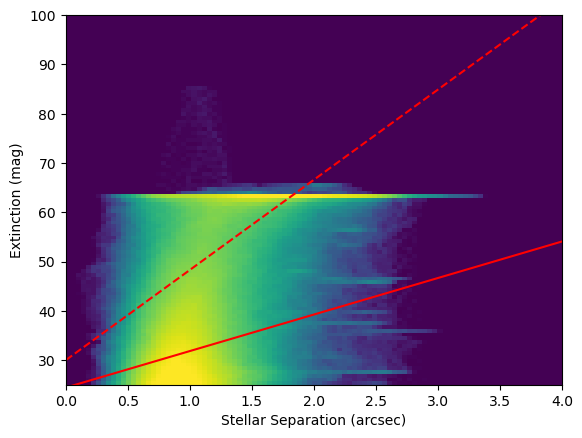

In [30]:
norm = simple_norm(h, 'log', percent=99)
plt.imshow(h.T, origin='lower', aspect='auto', extent=(0, 4, 25, 100), norm=norm)
#plt.plot([1.0, 1.5], [40, 70], color='red', linestyle='--')
plt.plot(bins_x, y, color='red', linestyle='--')
plt.plot(bins_x, fitted_line(bins_x), color='red')
plt.xlabel('Stellar Separation (arcsec)')
plt.ylabel('Extinction (mag)')
plt.ylim(25, 100)

In [31]:
#d = 5/sep**2 => sep = sqrt(5/d)
sep = np.sqrt(5/1.5)
sep

1.8257418583505538

In [32]:
sep = 3.6
d = 5/sep**2
d

0.38580246913580246

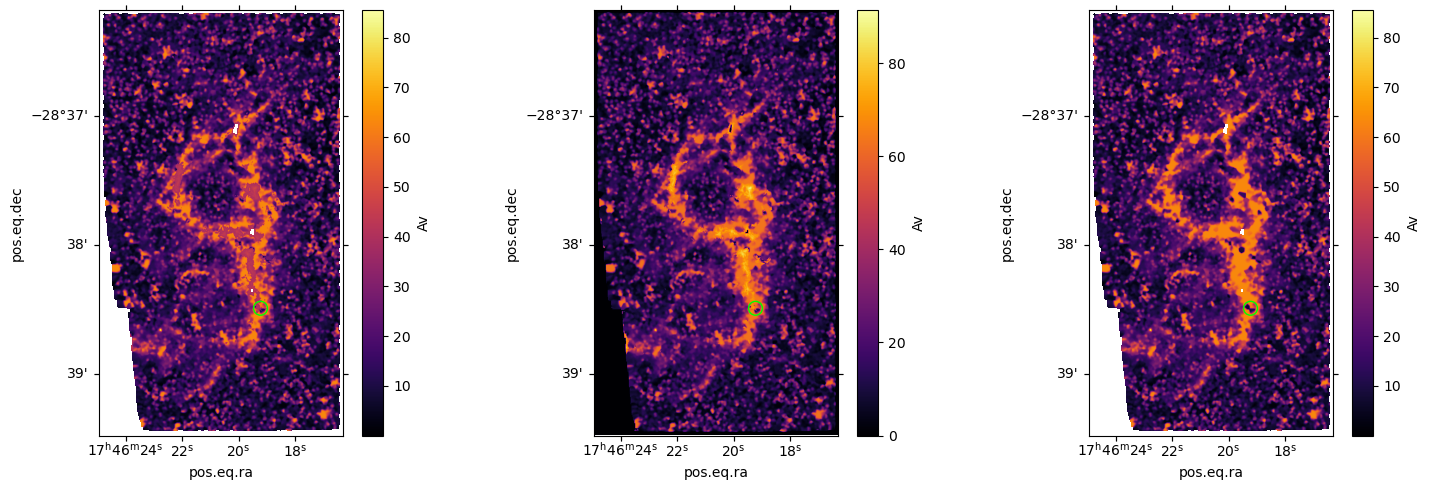

In [33]:
fig = plt.figure(figsize=(15, 5))

clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))

ext_copy = ext_map.copy()
#ext_copy[stellar_density_map < 1.5] = np.nan
separation_Av = fitted_line(separation_map)#m*separation_map+b
ext_copy[stellar_density_map < 1.5] = np.nan#m*separation_map+b
ext_copy = np.nansum([ext_copy, separation_Av*np.isnan(ext_copy)], axis=0)
ext_copy[separation_map > 3.6] = np.nan
ext_copy[ext_copy <= 0] = np.nan
ext_copy[mask_ext] = np.nan

ax = plt.subplot(131, projection=ww)
im = ax.imshow(ext_copy, origin='lower', cmap='inferno')
ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
plt.colorbar(im, label='Av', ax=ax)

plt.tight_layout()

ext_copy = ext_map.copy()
#ext_copy[stellar_density_map < 1.5] = np.nan
separation_Av = m*separation_map+b
ext_copy[stellar_density_map < 1.5] = np.nan#m*separation_map+b
ext_copy = np.nansum([ext_copy, separation_Av*np.isnan(ext_copy)], axis=0)
ext_copy[separation_map > 3.6] = np.nan
ext_copy[mask_ext] = np.nan

ax = plt.subplot(132, projection=ww)
im = ax.imshow(ext_copy, origin='lower', cmap='inferno')
ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
plt.colorbar(im, label='Av', ax=ax)

plt.tight_layout()

ax = plt.subplot(133, projection=ww)

im = ax.imshow(ext_map, origin='lower', cmap='inferno')
ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
plt.colorbar(im, label='Av', ax=ax)

plt.tight_layout()

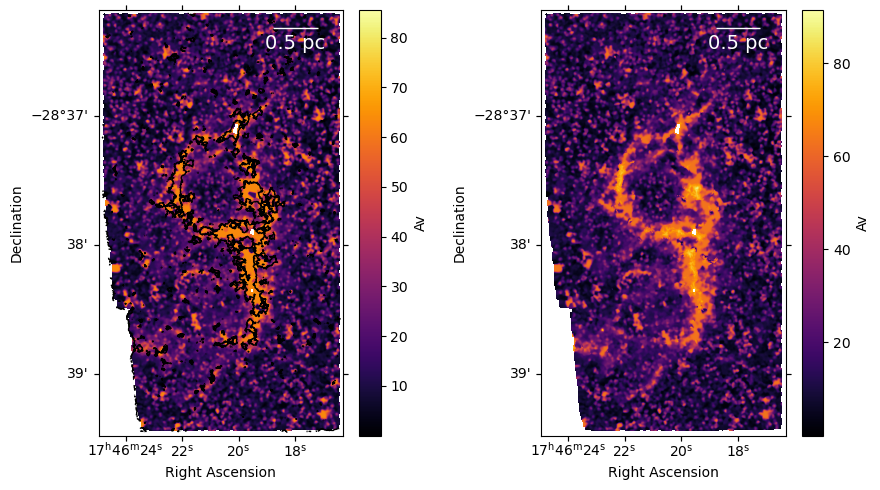

In [34]:
fig = plt.figure(figsize=(9, 5))

ext_copy = ext_map.copy()
#ext_copy[stellar_density_map < 1.5] = np.nan
separation_Av = m*separation_map+b
ext_copy[stellar_density_map < 1.5] = np.nan#m*separation_map+b
ext_copy = np.nansum([ext_copy, separation_Av*np.isnan(ext_copy)], axis=0)
ext_copy[separation_map > 3.6] = np.nan
ext_copy[ext_copy <= 0] = np.nan
ext_copy[mask_ext] = np.nan

ax = plt.subplot(122, projection=ww)
im = ax.imshow(ext_copy, origin='lower', cmap='inferno')
#ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})

plt.tight_layout()

ax = plt.subplot(121, projection=ww)

ext_copy2 = ext_map.copy()
ext_copy2[separation_map > 3.6] = np.nan
#ext_copy2[ext_copy2 <= 5] = np.nan
ext_copy2[mask_ext] = np.nan

im = ax.imshow(ext_copy2, origin='lower', cmap='inferno')
#ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
ax.contour(separation_map, levels=[1.5], colors='k', linewidths=1)
plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})

plt.tight_layout()
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/extinction_maps.pdf', bbox_inches='tight')

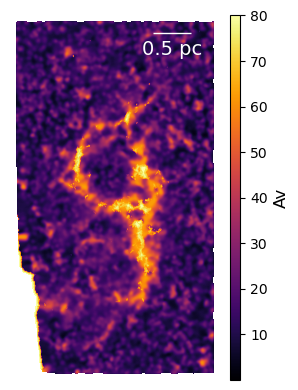

In [67]:
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot(111, projection=ww)
im = ax.imshow(ext_copy, origin='lower', cmap='inferno', vmax=80)
#ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
cbax = ax.inset_axes([1.05, 0.0, 0.05, 1])  
cbar = plt.colorbar(mappable=im, cax=cbax)
cbar.set_label("Av", fontsize=12)
#plt.colorbar(im, label='Av', ax=ax) 
ax.set_xlabel('Right Ascension', fontsize=10)
ax.set_ylabel('Declination', fontsize=10)
ax.set_axis_off()
plt.tight_layout()
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/poster_extinction_map.svg', dpi=300, bbox_inches='tight')

In [68]:
np.nanmax(ext_copy)

95.86005423536747

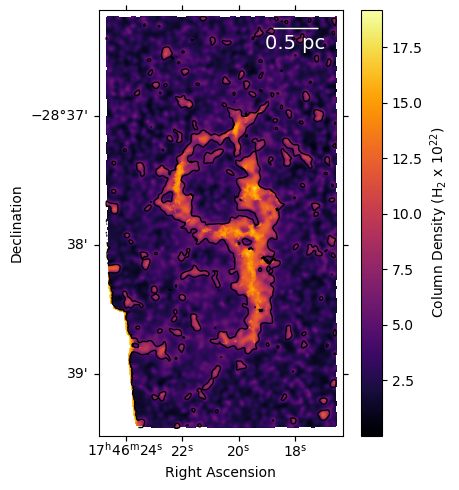

In [69]:
fig = plt.figure(figsize=(5, 5))

ext_copy = ext_map.copy()
#ext_copy[stellar_density_map < 1.5] = np.nan
separation_Av = m*separation_map+b
ext_copy[stellar_density_map < 1.5] = np.nan#m*separation_map+b
ext_copy = np.nansum([ext_copy, separation_Av*np.isnan(ext_copy)], axis=0)
ext_copy[separation_map > 3.6] = np.nan
ext_copy[ext_copy <= 0] = np.nan
ext_copy[mask_ext] = np.nan

ax = plt.subplot(111, projection=ww)
im = ax.imshow(ext_copy*0.2, origin='lower', cmap='inferno')
#ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='lime', facecolor='none')
ax.contour(ext_copy, levels=[30], colors='k', linewidths=1)
plt.colorbar(im, label='Column Density (H$_2$ x 10$^{22}$)', ax=ax)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
add_scalebar(ax, theta_arcsec, color='white', label='0.5 pc', corner='top right', fontproperties={"size": 14})


plt.tight_layout()
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/column_density.pdf', bbox_inches='tight')

In [70]:
mass_1 = ex.get_mass_estimate(ext_copy, ww, dist=5*u.kpc, factor=2*10**21*u.cm**-2, mpp=2.8*u.u)
mass_1

<Quantity 10890.48191137 solMass>

In [ ]:
hdu_Av = fits.PrimaryHDU(ext_copy, header=ww.to_header())
#hdu_Av.writeto('/orange/adamginsburg/jwst/cloudc/images/filament_av_map.fits', overwrite=True)

In [ ]:
print(

## Outflows

In [71]:
def get_percentile_list(data, percents=[98, 99, 99.9, 99.99]):
    #[87, 95, 99, 99.5, 99.9, 99.99]
    arr = []
    for per in percents:
        arr.append(np.nanpercentile(data, per))
    return np.array(arr)

In [72]:
clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
clump2 = SkyCoord('17:46:19.5945777603', '-28:38:09.9402161687', unit=(u.hourangle, u.deg))

clump1_SiO_mom0_low = mm.get_ACES_mom0(clump1, 25*u.arcsec, 25*u.arcsec, 'SiO 2-1', -60*u.km/u.s, -55*u.km/u.s)
clump1_SiO_mom0_high = mm.get_ACES_mom0(clump1, 25*u.arcsec, 25*u.arcsec, 'SiO 2-1', -55*u.km/u.s, -50*u.km/u.s)

clump2_SiO_mom0_low = mm.get_ACES_mom0(clump2, 10*u.arcsec, 10*u.arcsec, 'SiO 2-1', -60*u.km/u.s, -55*u.km/u.s)
clump2_SiO_mom0_high = mm.get_ACES_mom0(clump2, 10*u.arcsec, 10*u.arcsec, 'SiO 2-1', -55*u.km/u.s, -50*u.km/u.s)

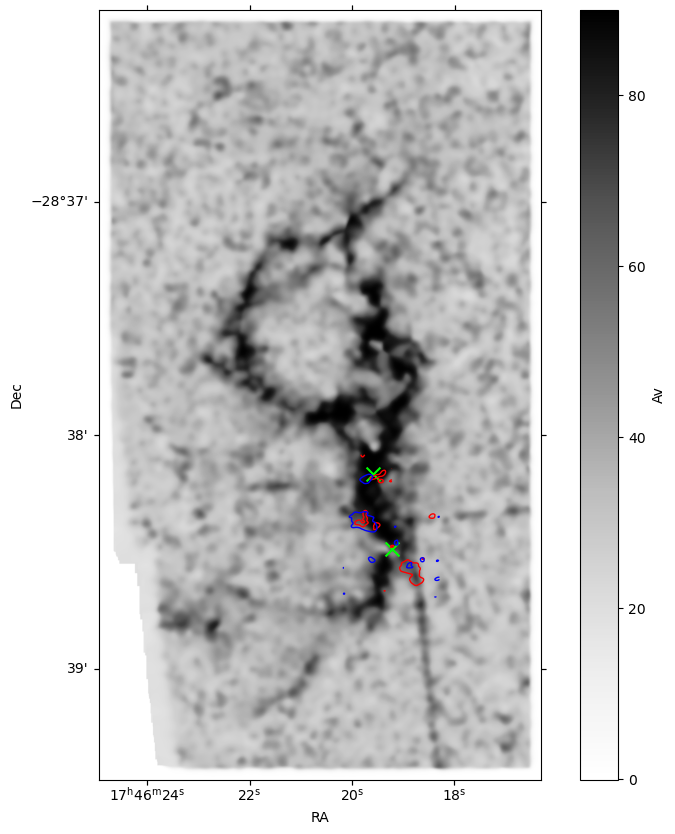

In [73]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=ww)

im = ax.imshow(ext_map, origin='lower', cmap='Greys')

ax.scatter(clump1.ra.deg, clump1.dec.deg, color='lime', transform=ax.get_transform('world'), marker='x', s=100)
ax.contour(clump1_SiO_mom0_low.data, levels=[np.percentile(clump1_SiO_mom0_low.data, 95)], colors='red', transform=ax.get_transform(clump1_SiO_mom0_low.wcs), linewidths=1)
ax.contour(clump1_SiO_mom0_high.data, levels=[np.percentile(clump1_SiO_mom0_high.data, 95)], colors='blue', transform=ax.get_transform(clump1_SiO_mom0_high.wcs), linewidths=1)

ax.scatter(clump2.ra.deg, clump2.dec.deg, color='lime', transform=ax.get_transform('world'), marker='x', s=100)
ax.contour(clump2_SiO_mom0_low.data, levels=[np.percentile(clump2_SiO_mom0_low.data, 95)], colors='red', transform=ax.get_transform(clump2_SiO_mom0_low.wcs), linewidths=1)
ax.contour(clump2_SiO_mom0_high.data, levels=[np.percentile(clump2_SiO_mom0_high.data, 95)], colors='blue', transform=ax.get_transform(clump2_SiO_mom0_high.wcs), linewidths=1)

plt.colorbar(im, label='Av', ax=ax)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')